In [1]:
%pylab inline
import os
from IPython import display
import time
import concurrent.futures as fs


Populating the interactive namespace from numpy and matplotlib


In [2]:
state_path = "/home/ubuntu/atari_states/"

In [15]:
states = [os.path.join(state_path, x) for x in sorted(os.listdir(state_path)) if x[-3:] == "npy"]

In [16]:
train_states = states[:100]
test_states = states[100:200]

In [5]:
def load_atari_states(states):
    executor = fs.ThreadPoolExecutor(20)
    futures = []
    for state in states:
        futures.append(executor.submit(lambda x: np.load(x)[:, :], state))
    fs.wait(futures)
    all_data = np.vstack([f.result() for f in futures])
    X = all_data[:, :-2]
    y = all_data[:, -2]
    return X, y
    
    
    

In [51]:
%time X_train, y_train = load_atari_states(train_states)

CPU times: user 41.3 s, sys: 2min 55s, total: 3min 36s
Wall time: 1min 43s


In [25]:
state_0, actions_0 = load_atari_states(train_states[:1])

In [26]:
import skimage.feature as feature
from skimage.color import rgb2gray

In [189]:
img = None
all_features = []
for i in range(0,1,20):
    im = state_0[i].reshape(210,160,3)
    features = np.zeros((30,20,3,30,20,3))
    blobs = []
    colors = []
    for c in range(3):
        im_edges = feature.canny(im[:, :, c])
        blobs_dog = feature.blob_dog(im_edges, max_sigma=5, threshold=.2)
        blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
        blobs.append(blobs_dog)
        for _ in blobs_dog:
            colors.append(c)
        for b in blobs_dog:
            features[int(b[0]/7), int(b[1]/8), c] = b[2] 
    blobs = np.vstack(blobs)
    colors = np.vstack(colors)
    blob_loc = blobs[:,:2]
    blob_loc[:,0] /= 7
    blob_loc[:,1] /= 8
    blob_loc = blob_loc.astype('int')
    blob_norms = np.linalg.norm(blob_loc, axis=1)[:, np.newaxis]
    D = blob_norms + -2*blob_loc.dot(blob_loc.T) + blob_norms.T
    for i,row in enumerate(D):
        idx0,idx1 = blob_loc[i]
        c1 = colors[i]
        for j,elem in enumerate(row):
            idx2,idx3 = blob_loc[j]
            c2 = colors[j]
            features[idx0,idx1,c1,idx2,idx3,c2] = elem
            
    all_features.append(features.ravel())


In [195]:
X = np.vstack(all_features[:1024])

In [ ]:
np.csingl

In [202]:
def patchify(img, patch_shape, pad=False, pad_mode='constant', cval=0):
    ''' Function borrowed from:
    http://stackoverflow.com/questions/16774148/fast-way-to-slice-image-into-overlapping-patches-and-merge-patches-to-image
    '''
    #FIXME: Make first two coordinates of output dimension shape as img.shape always

    if pad:
        pad_size= (patch_shape[0]/2, patch_shape[0]/2)
        img = np.pad(img, (pad_size, pad_size, (0,0)),  mode=pad_mode, constant_values=cval)

    img = np.ascontiguousarray(img)  # won't make a copy if not needed

    X, Y, Z = img.shape
    x, y= patch_shape
    shape = ((X-x+1), (Y-y+1), x, y, Z) # number of patches, patch_shape
    # The right strides can be thought by:
    # 1) Thinking of `img` as a chunk of memory in C order
    # 2) Asking how many items through that chunk of memory are needed when indices
#    i,j,k,l are incremented by one
    strides = img.itemsize*np.array([Y*Z, Z, Y*Z, Z, 1])
    patches = np.lib.stride_tricks.as_strided(img, shape=shape, strides=strides)
    return patches

def learn_gamma(patches, sample_size=3000, percentile=10, weight=1.414):
    patches = patches.reshape(-1,patches.shape[2]*patches.shape[3]*patches.shape[-1])
    x_indices = np.random.choice(patches.shape[0], sample_size)
    y_indices = np.random.choice(patches.shape[0], sample_size)
    x = patches[x_indices]
    y = patches[y_indices]
    x_norm = np.maximum(np.linalg.norm(x, axis=1), 1e-16)[:,np.newaxis]
    y_norm = np.maximum(np.linalg.norm(y, axis=1), 1e-16)[:,np.newaxis]
    x = x/x_norm
    y = y/y_norm
    diff = x - y
    norms = np.linalg.norm(diff, axis=1)
    return 1.0/((1.0/weight * np.median(norms))**2)

In [198]:
features.shape

(30, 20, 3, 30, 20, 3)

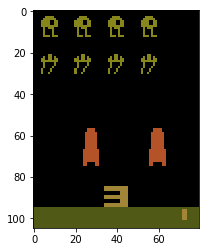

In [221]:
imshow(patchify(im, (105,80))[100,50])


In [155]:
blob_locs = blobs_dog[:, :2]
blob_norms = np.linalg.norm(blob_locs, axis=1)[: , np.newaxis]

In [156]:
D = blob_norms + -2*blob_locs.dot(blob_locs.T) + blob_norms.T


(3,)

In [123]:
im = state_0[0].reshape(210,160,3)
channel_features = []
for c in range(3):
    print(c)
    print(im)
    im_edges = feature.canny(im[:,:, c])
    blobs_dog = feature.blob_dog(im_edges, max_sigma=5, threshold=.2)
    print(blobs_dog)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    #img = imshow(im)

    for blob in blobs_dog:
        y, x, r = blob
        c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
        img.axes.add_patch(c)
    #plt.figure()
    display.clear_output(wait=True)
    display.display(gcf())

    features = np.zeros((int(im.shape[0]/7), int(im.shape[1]/3)))
    for b in blobs_dog:
        features[int(b[0]/7), int(b[1]/3)] = b[2]
    channel_features.append(features)
            
    
        
        
        
        
    
    


In [128]:
np.stack(channel_features)

array([[[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        ..., 
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        ..., 
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 

In [96]:
features.shape

(30, 40)

In [80]:
30 * 40

1200

In [70]:
im.shape

(210, 160, 3)

In [48]:
edges = []
for i in range(0,X.shape[0],10):
    im = X_train[i,:].reshape(210, 160,3)
    edges.append(im_edges.ravel().astype('float32'))
X_train_edges = np.vstack(edges)

In [49]:
X_train_edges.shape

(1000, 33600)

In [50]:
len(test_states)

9

In [54]:

%time im_edges = feature.canny(rgb2gray(im))

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 18 ms
